In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
import string
import nltk
from gensim.utils import simple_preprocess
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

nltk.download('punkt')

Generating train split:   0%|          | 0/129433 [00:00<?, ? examples/s]

# preparing the data

In [21]:
CREATE_CSV = False
SAMPLE = False

if CREATE_CSV:
    dataset = load_dataset("allmalab/azwiki")
    dataset['train'].to_pandas()[['text']].to_csv('azwiki.csv', index=False)

df = pd.read_csv('azwiki.csv')
if SAMPLE:
    df = df.sample(1000).reset_index(drop=True)
df

,text
0,Svyatoslav İvanoviç Vakarçuk ukraynalı müğənni...
1,Bruselyoz zoonoz infeksion-allergik xəstəlikdi...
2,ArgentinaTürkiyə münasibətləri Argentina ilə T...
3,Kim Jin-Son Cənubi Koreyanı təmsil edən həndbo...
4,Likiyalılar - Qədim dövrdə Anadolunun Likiya b...
...,...
129428,Nərman Fəzaim oğlu Rəsulov Azərbaycan Silahlı ...
129429,Atabəylər Memarlıq Kompleksi Naxçıvan şəhərind...
129430,Spotify Wrapped isveçli media yayım xidməti Sp...
129431,"Gömeç qülləsi Cənubi Türkiyədə, tarixi Kilikiy..."


In [22]:
# tokenization
df['tokenized_text'] = [simple_preprocess(line) for line in df['text']] 
print(df['tokenized_text'].head(10))

0    [svyatoslav, vanoviç, vakarçuk, ukraynalı, müğ...
1    [bruselyoz, zoonoz, infeksion, allergik, xəstə...
2    [münasibətləri, argentina, ilə, türkiyə, arası...
3    [kim, jin, son, cənubi, koreyanı, təmsil, edən...
4    [likiyalılar, qədim, dövrdə, anadolunun, likiy...
5    [mikayıl, gözəlov, şuşa, rayon, cra, hakimiyyə...
6    [mirzə, məhəmmədəli, xan, hacı, mirzə, fətəli,...
7    [əbdül, hüseynəli, oğlu, qasımov, azərbaycanın...
8    [lgbt, cəmiyyəti, ortaq, bir, mədəniyyət, və, ...
9    [qasımov, muxtar, cahid, oğlu, azərbaycanın, m...
Name: tokenized_text, dtype: object


# statistics

Number of Documents: 129433
Total Number of Words: 33299954
Number of Distinct Words: 1700280
Number of Frequent Words: 663535
Number of Rare Words: 1036745


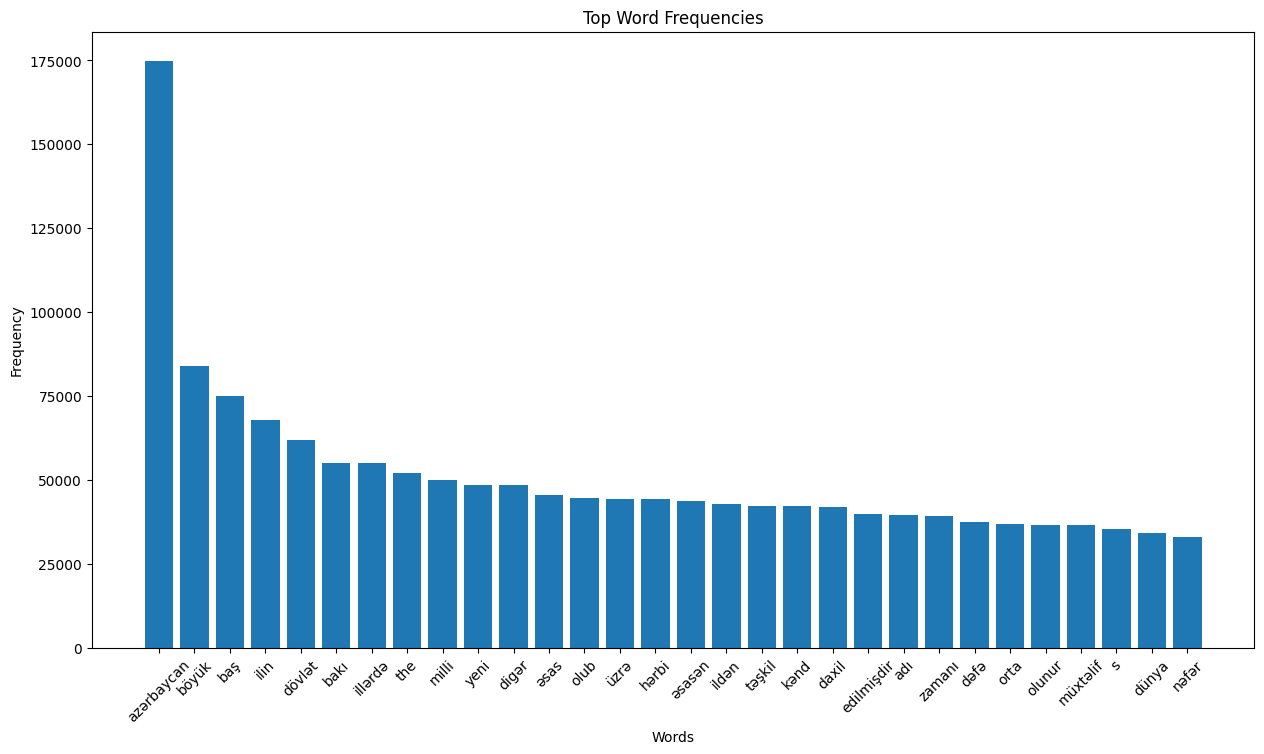

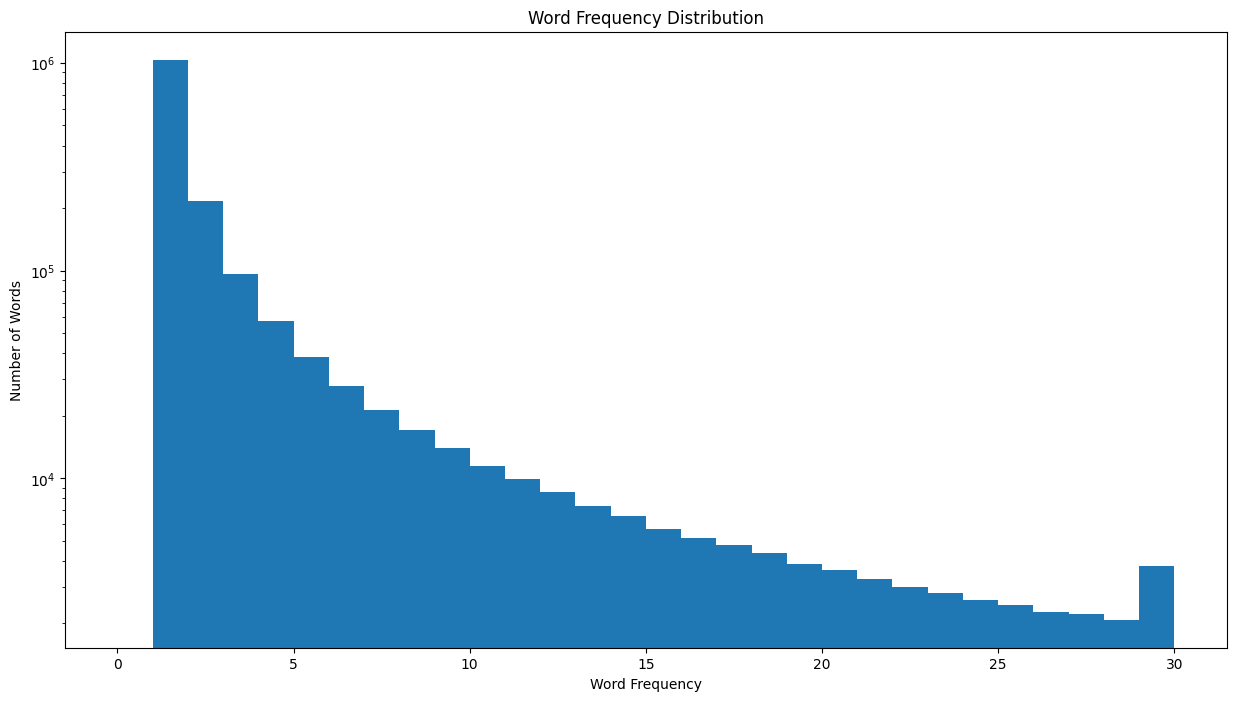

In [109]:
# Preprocessing and Tokenization for Visualization
def preprocess_text(text):
    # Convert text to lowercase, remove punctuation, and tokenize
    lower_text = text.lower()
    no_punc_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(no_punc_text)
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

df['tokenized_vis'] = df['text'].apply(preprocess_text)

# Flatten the list of tokens and count distinct words
all_tokens = [token for sublist in df['tokenized_vis'] for token in sublist]
token_counts = Counter(all_tokens)

# Basic Statistics
num_documents = len(df)
total_words = len(all_tokens)
distinct_words = len(token_counts)

# Frequency Analysis
frequent_words = {word: count for word, count in token_counts.items() if count > 1}  # Adjust criteria as needed
rare_words = {word: count for word, count in token_counts.items() if count == 1}

print(f"Number of Documents: {num_documents}")
print(f"Total Number of Words: {total_words}")
print(f"Number of Distinct Words: {distinct_words}")
print(f"Number of Frequent Words: {len(frequent_words)}")
print(f"Number of Rare Words: {len(rare_words)}")


# Plotting the top N most common words
N = 30
top_words = token_counts.most_common(N)
words, frequencies = zip(*top_words)

plt.figure(figsize=(15, 8))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Word Frequencies')
plt.xticks(rotation=45)
plt.show()

# Plotting word frequency distribution
frequencies = list(token_counts.values())
plt.figure(figsize=(15, 8))
plt.hist(frequencies, bins=30, range=[0, 30])  # Adjust bin range based on your dataset
plt.yscale('log', nonpositive='clip')  # Log scale for better visibility of rare words
plt.title('Word Frequency Distribution')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.show()


In [111]:
# less frequent words
N = 30
bottom_words = token_counts.most_common()[:-N-1:-1]
words, frequencies = zip(*bottom_words)
words

('praysuoterxauskuper',
 'administriasiyası',
 'qazpromda',
 '90inə',
 'təxsisatlarının',
 'hasiledicilər',
 'normativhuquqi',
 'ödənişqabiliyyətinin',
 'renovasiyasını',
 'fasiləliyə',
 'qeyriödənişli',
 'durugönül',
 'kalikadnos',
 'kərpiclənmiş',
 'ərdəmlinin',
 'edildiartush',
 'centrasia',
 'artush',
 'oldumina',
 'istədilərqurban',
 'şirvanşirə',
 'ilahim',
 'nisvanları',
 'sevəcəkmiş',
 'alnamına',
 'qabaradaraq',
 'almışdırencyclopdia',
 'homosexualities',
 'tropes',
 'corporealizing')

# Training Word2Vec

In [23]:
import os
import time
import multiprocessing
from gensim.models import Word2Vec

# skip-gram model with sg=1
vector_size = 1024
window = 3
min_count = 1
workers = multiprocessing.cpu_count()
sg = 1
print("Number of workers: ", workers) # 11 on my machine

OUTPUT_FOLDER = 'output/'

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

word2vec_model_file = OUTPUT_FOLDER + 'word2vec_' + str(vector_size) + '.model'
start_time = time.time()
stemmed_tokens = pd.Series(df['tokenized_text']).values

w2v_model = Word2Vec(
    stemmed_tokens, 
    min_count=min_count,
    vector_size=vector_size,
    workers=workers,
    window=window,
    sg=sg
)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

Number of workers:  11
Time taken to train word2vec model: 2477.890780210495


In [ ]:
# Load the model from the model file
w2v_model = Word2Vec.load(word2vec_model_file)
# Unique ID of the word
print("Index of the word 'salam':")
print(w2v_model.wv.key_to_index["salam"])
# Total number of the words 
print(len(w2v_model.wv))
# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(w2v_model.wv['salam']))
# Get the mean for the vectors for an example review
print("Print the length after taking average of all word vectors in a sentence:")
print(np.mean([w2v_model.wv[token] for token in df['tokenized_text'][0]], axis=0))


In [24]:
# Use your model for finding synonyms (or words with similar meaning) for 10 different words. Was your model accurate? Describe results.
# Load the model
w2v_model = Word2Vec.load(word2vec_model_file)

# Find synonyms for the word 'dünya'
print("Synonyms for 'dünya':")
print(w2v_model.wv.most_similar('dünya'))

print("Synonyms for 'azərbaycan':")
print(w2v_model.wv.most_similar('azərbaycan'))

# Apply mathematical equations on vector values of similar words. Are there any patterns visible? Describe results.
# Find the odd one out
print("Odd one out of 'dünya, torpaq, planet, qlobus':")
print(w2v_model.wv.doesnt_match(['dünya', 'torpaq', 'planet', 'qlobus']))

# Find the word that is similar to the result of the following equation: dünya - insan + ailə
print("Similar word to 'dünya - insan + ailə':")
print(w2v_model.wv.most_similar(positive=['dünya', 'ailə'], negative=['insan']))

# Find the word that is similar to the result of the following equation: azərbaycan - baku + london
print("Similar word to 'azərbaycan - bakı + london':")
print(w2v_model.wv.most_similar(positive=['azərbaycan', 'london'], negative=['bakı']))

# Find the word that is similar to the result of the following equation: kral + qadın - kişi
print("Similar word to 'kral + qadın - kişi':")
print(w2v_model.wv.most_similar(positive=['kral', 'qadın'], negative=['kişi']))

# Find the word that is similar to the result of the following equation: qadın + atası - anası
print("Similar word to 'qadın + atası - anası':")
print(w2v_model.wv.most_similar(positive=['qadın', 'atası'], negative=['anası']))


Synonyms for 'dünya':
[('dunya', 0.5467132329940796), ('rekordları', 0.5327008962631226), ('klublararası', 0.5305799841880798), ('avopa', 0.5218081474304199), ('wako', 0.5183637142181396), ('çempionatları', 0.5162598490715027), ('dünyü', 0.5159988403320312), ('blits', 0.5137833952903748), ('rusiyaukrayna', 0.5137462615966797), ('çempionatındakı', 0.5134212374687195)]
Synonyms for 'azərbaycan':
[('azərbacan', 0.7431983947753906), ('azərbayan', 0.7275598049163818), ('azərbayca', 0.7157527208328247), ('azərbycan', 0.7142782211303711), ('azəbaycan', 0.7119920253753662), ('azərbayacan', 0.7083905935287476), ('azəraycan', 0.706139862537384), ('azərbayjan', 0.6947520971298218), ('zərbaycan', 0.6904098391532898), ('azarbaycan', 0.6732813119888306)]
Odd one out of 'dünya, torpaq, planet, qlobus':
torpaq
Similar word to 'dünya - insan + ailə':
[('dunya', 0.36704736948013306), ('odina', 0.3325014114379883), ('sopelniklə', 0.33048632740974426), ('qurmayıb', 0.3213329017162323), ('olimpiyadası', 0.

In [89]:
print("Similar word to 'kral + qadın - kişi':")
similar_words = w2v_model.wv.most_similar(positive=['kral', 'qadın'], negative=['kişi'])
for word, similarity in similar_words:
    print(f"{word}: {similarity:.2f}")

Similar word to 'kral + qadın - kişi':
kralın: 0.43
kralının: 0.40
kralı: 0.38
kraliça: 0.38
bukinqem: 0.38
kraliyyət: 0.37
kraliçanın: 0.37
georqun: 0.36
vilhelmin: 0.36
kraliçası: 0.36


In [83]:
# Use your model for finding synonyms (or words with similar meaning) for 10 different words.
words = ['dünya', 'torpaq', 'planet', 'qlobus', 'azərbaycan', 'baku', 'paris', 'kral', 'qadın', 'kişi']
words = ['kral', 'qadın', 'həkim', 'ata', 'at', 'az', 'görmək', 'yoxlamaq','başlamaq', 'tapmaq']

# pretty print synonyms with their similarity scores with 2 decimal places
for word in words:
    print(f"Synonyms for '{word}':")
    for synonym, score in w2v_model.wv.most_similar(word):
        print(f"{synonym}: {score:.2f}")
    print()

Synonyms for 'kral':
kralı: 0.54
kralın: 0.48
kralının: 0.47
kraliyyət: 0.46
kraliça: 0.46
bukinqem: 0.46
mperator: 0.46
frederikin: 0.45
monarx: 0.45
georqun: 0.44

Synonyms for 'qadın':
kişi: 0.63
qadınların: 0.52
qadının: 0.51
qadını: 0.48
qadındır: 0.45
qadınları: 0.45
qadınlardan: 0.44
qadına: 0.43
qadınlar: 0.43
kişilərin: 0.43

Synonyms for 'həkim':
cərrah: 0.61
terapevt: 0.58
ginekoloq: 0.58
uroloq: 0.56
həkimi: 0.56
nevropatoloq: 0.56
stomatoloq: 0.55
oftalmoloq: 0.55
psixiatr: 0.54
feldşer: 0.54

Synonyms for 'ata':
baba: 0.52
oğul: 0.51
babadan: 0.49
atanın: 0.49
nənə: 0.48
atadan: 0.47
babası: 0.47
babalarından: 0.46
babasının: 0.46
oğulun: 0.46

Synonyms for 'at':
belində: 0.48
ilxısı: 0.45
nalı: 0.45
dözər: 0.45
çapmaq: 0.44
çaparkən: 0.44
minməkdə: 0.44
dəvə: 0.44
yüyənli: 0.43
oberpullendorf: 0.43

Synonyms for 'az':
kulis: 0.45
aznews: 0.44
gov: 0.44
miqdarda: 0.43
anspress: 0.43
anl: 0.43
publika: 0.43
azframework: 0.42
biraz: 0.42
azarticles: 0.42

Synonyms for 'görm

In [84]:
azerbaijani_word_arrays = [
    ['dünya', 'torpaq', 'planet', 'qlobus'],
    ["qırmızı", "mavi", "yaşıl", "it"],
    ['günəş', 'ay', 'ulduz', 'ağac'],
    ['kitab', 'qəzet', 'telefon', 'qalereya']
]
for word_array in azerbaijani_word_arrays:
    result = w2v_model.wv.doesnt_match(word_array)
    print("Words in array:", word_array)
    print("Predicted word that doesn't match:", result)
    print()

Words in array: ['dünya', 'torpaq', 'planet', 'qlobus']
Predicted word that doesn't match: torpaq

Words in array: ['qırmızı', 'mavi', 'yaşıl', 'it']
Predicted word that doesn't match: it

Words in array: ['günəş', 'ay', 'ulduz', 'ağac']
Predicted word that doesn't match: ağac

Words in array: ['kitab', 'qəzet', 'telefon', 'qalereya']
Predicted word that doesn't match: telefon



# Prepare the data for the GloVe model training

In [31]:
file_path = '/Users/eljan/Documents/NLP/NLP-Course-ADA/course-projrct-4/GloVe/corpus.txt'
with open(file_path, 'w', encoding='utf-8') as file:
    for index, row in df.iterrows():
        document_text = ' '.join(row['tokenized_text'])
        file.write(document_text + '\n')

df

,text,tokenized_text
0,Svyatoslav İvanoviç Vakarçuk ukraynalı müğənni...,"[svyatoslav, vanoviç, vakarçuk, ukraynalı, müğ..."
1,Bruselyoz zoonoz infeksion-allergik xəstəlikdi...,"[bruselyoz, zoonoz, infeksion, allergik, xəstə..."
2,ArgentinaTürkiyə münasibətləri Argentina ilə T...,"[münasibətləri, argentina, ilə, türkiyə, arası..."
3,Kim Jin-Son Cənubi Koreyanı təmsil edən həndbo...,"[kim, jin, son, cənubi, koreyanı, təmsil, edən..."
4,Likiyalılar - Qədim dövrdə Anadolunun Likiya b...,"[likiyalılar, qədim, dövrdə, anadolunun, likiy..."
...,...,...
129428,Nərman Fəzaim oğlu Rəsulov Azərbaycan Silahlı ...,"[nərman, fəzaim, oğlu, rəsulov, azərbaycan, si..."
129429,Atabəylər Memarlıq Kompleksi Naxçıvan şəhərind...,"[atabəylər, memarlıq, kompleksi, naxçıvan, şəh..."
129430,Spotify Wrapped isveçli media yayım xidməti Sp...,"[spotify, wrapped, isveçli, media, yayım, xidm..."
129431,"Gömeç qülləsi Cənubi Türkiyədə, tarixi Kilikiy...","[gömeç, qülləsi, cənubi, türkiyədə, tarixi, ki..."


In [27]:
print(w2v_model.wv.most_similar(positive=['azərbaycan', 'paris'], negative=['bakı']))

[('nationale', 0.42391499876976013), ('france', 0.4190831184387207), ('parisdə', 0.4109044671058655), ('konfransındakı', 0.4083888530731201), ('zuavları', 0.4050668179988861), ('parisdəki', 0.4021584093570709), ('fransanın', 0.4014906883239746), ('slem', 0.3975769281387329), ('fransa', 0.3974057137966156), ('demokraik', 0.3958333432674408)]


# Training GloVe model

In [ ]:
# train GLoVe model using stanfordnlp/glove
# commands to run in terminal

# main parameters: -vector-size, -iter

"""
git clone https://github.com/stanfordnlp/GloVe.git
cd GloVe
make
build/vocab_count -min-count 3 -verbose 2 < corpus.txt > vocab.txt
build/cooccur -memory 4.0 -vocab-file vocab.txt -verbose 2 -window-size 15 < corpus.txt > cooccurrence.bin
build/shuffle -memory 4.0 -verbose 2 < cooccurrence.bin > cooccurrence.shuf.bin
build/glove -save-file vectors -ts hreads 8 -input-file cooccurrence.shuf.bin -x-max 10 -iter 20 -vector-size 128 -binary 2 -vocab-file vocab.txt -verbose 2
"""

In [123]:
glove_input_file = 'GloVe/vectors.txt'
word2vec_output_file = 'GloVe/glove_model.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

gl_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

/var/folders/ls/65g9k4kd4_j8k3x277xdkd500000gn/T/ipykernel_81218/3091143107.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [124]:
print(gl_model.most_similar('dünya'))
print(gl_model.doesnt_match(['dünya', 'torpaq', 'planet', 'qlobus']))
print(gl_model.most_similar(positive=['dünya', 'ailə'], negative=['insan']))

[('çempinatına', 0.7726320028305054), ('avropa', 0.7445871829986572), ('müharibəsindən', 0.6348709464073181), ('birinci', 0.6346476078033447), ('dünyada', 0.6216305494308472), ('çempionatında', 0.619340717792511), ('dünyanın', 0.6168348789215088), ('kinci', 0.6153126955032349), ('çempionatı', 0.6149469017982483), ('çempionu', 0.6058913469314575)]
qlobus
[('yoldaşı', 0.5234764218330383), ('çempinatına', 0.5218350291252136), ('çempionatı', 0.5111365914344788), ('rusiya', 0.5031629204750061), ('birinci', 0.49001172184944153), ('illər', 0.4884110391139984), ('cu', 0.4843294024467468), ('çempionatında', 0.4834398031234741), ('komanda', 0.4763185381889343), ('xanım', 0.47060462832450867)]


In [125]:
# Use your model for finding synonyms (or words with similar meaning) for 10 different words.
words = ['dünya', 'torpaq', 'planet', 'qlobus', 'azərbaycan', 'baku', 'paris', 'kral', 'qadın', 'kişi']
words = ['kral', 'qadın', 'həkim', 'ata', 'at', 'az', 'görmək', 'yoxlamaq','başlamaq', 'tapmaq']

# pretty print synonyms with their similarity scores with 2 decimal places
for word in words:
    print(f"Synonyms for '{word}':")
    for synonym, score in gl_model.most_similar(word):
        print(f"{synonym}: {score:.2f}")
    print()

Synonyms for 'kral':
kralı: 0.71
kralın: 0.66
henri: 0.63
demusinin: 0.63
mperator: 0.62
imperator: 0.61
mobon: 0.61
kraliça: 0.60
teconq: 0.60
şahzadə: 0.60

Synonyms for 'qadın':
kişi: 0.83
qadınların: 0.70
gənc: 0.69
qadının: 0.68
yaşlı: 0.67
qadını: 0.65
qız: 0.64
qadınlar: 0.61
qadınları: 0.61
təkbuynuzla: 0.60

Synonyms for 'həkim':
həkimi: 0.75
tibb: 0.69
cərrah: 0.67
ryö: 0.62
robotçu: 0.62
terapevt: 0.60
müəllim: 0.59
psixoloq: 0.59
professor: 0.59
alim: 0.58

Synonyms for 'ata':
baba: 0.67
ana: 0.65
babası: 0.64
oğul: 0.64
atanın: 0.61
doğma: 0.59
qorio: 0.58
anasının: 0.58
nənəsi: 0.57
ulu: 0.57

Synonyms for 'at':
ağboz: 0.67
umqebunq: 0.66
shift: 0.61
çapmağı: 0.61
tiroler: 0.60
minməkdə: 0.59
brukk: 0.59
austriancharts: 0.59
nalının: 0.58
belində: 0.58

Synonyms for 'az':
çox: 0.74
daha: 0.69
kifayət: 0.64
nisbətən: 0.64
vaxt: 0.63
artıq: 0.62
qədər: 0.62
bundan: 0.62
http: 0.61
xeyli: 0.61

Synonyms for 'görmək':
mümkündür: 0.78
olar: 0.74
göstərmək: 0.70
mümkün: 0.68
la

In [92]:
azerbaijani_word_arrays = [
    ['dünya', 'torpaq', 'planet', 'qlobus'],
    ["qırmızı", "mavi", "yaşıl", "it"],
    ['günəş', 'ay', 'ulduz', 'ağac'],
    ['kitab', 'qəzet', 'telefon', 'qalereya']
]
for word_array in azerbaijani_word_arrays:
    result = gl_model.doesnt_match(word_array)
    print("Words in array:", word_array)
    print("Predicted word that doesn't match:", result)
    print()

Words in array: ['dünya', 'torpaq', 'planet', 'qlobus']
Predicted word that doesn't match: qlobus

Words in array: ['qırmızı', 'mavi', 'yaşıl', 'it']
Predicted word that doesn't match: it

Words in array: ['günəş', 'ay', 'ulduz', 'ağac']
Predicted word that doesn't match: ağac

Words in array: ['kitab', 'qəzet', 'telefon', 'qalereya']
Predicted word that doesn't match: qalereya



In [127]:
print("Similar word to 'azərbaycan - bakı + paris:")
similar_words = gl_model.most_similar(positive=['azərbaycan', 'paris'], negative=['bakı'])
for word, similarity in similar_words:
    print(f"{word}: {similarity:.2f}")

Similar word to 'azərbaycan - bakı - kişi' + paris:
fransa: 0.64
parisdə: 0.53
fransanın: 0.52
skpo: 0.51
portulan: 0.51
de: 0.50
broli: 0.49
parisdəki: 0.49
baillire: 0.49
parisin: 0.47


In [128]:
print("Similar word to 'kral + qadın - kişi':")
similar_words = gl_model.most_similar(positive=['kral', 'qadın'], negative=['kişi'])
for word, similarity in similar_words:
    print(f"{word}: {similarity:.2f}")

Similar word to 'kral + qadın - kişi':
kralı: 0.65
henri: 0.62
britaniya: 0.61
kralın: 0.60
kraliça: 0.59
fransa: 0.56
kraliçası: 0.56
spaniya: 0.56
ngiltərə: 0.56
krallığının: 0.55


In [58]:
# Use your model for finding synonyms (or words with similar meaning) for 10 different words. Was your model accurate? 
# Find synonyms for the word 'dünya'
print("Synonyms for 'dünya':")
print(gl_model.most_similar('dünya'))


print("Synonyms for 'azərbaycan':")
print(gl_model.most_similar('azərbaycan'))

# Apply mathematical equations on vector values of similar words. Are there any patterns visible? Describe results.
# Find the odd one out
print("Odd one out of 'dünya, torpaq, planet, qlobus':")
print(gl_model.doesnt_match(['dünya', 'torpaq', 'planet', 'qlobus']))

# Find the word that is similar to the result of the following equation: dünya - insan + ailə
print("Similar word to 'dünya - insan + ailə':")
print(gl_model.most_similar(positive=['dünya', 'ailə'], negative=['insan']))

# Find the word that is similar to the result of the following equation: azərbaycan - baku + london
print("Similar word to 'azərbaycan - bakı + london':")
print(gl_model.most_similar(positive=['azərbaycan', 'london'], negative=['bakı']))

# Find the word that is similar to the result of the following equation: kral + qadın - kişi
print("Similar word to 'kral + qadın - kişi':")
print(gl_model.most_similar(positive=['kral', 'qadın'], negative=['kişi']))

# Find the word that is similar to the result of the following equation: qadın + atası - anası
print("Similar word to 'qadın + atası - anası':")
print(gl_model.most_similar(positive=['qadın', 'atası'], negative=['anası']))

print(gl_model.most_similar(positive=['azərbaycan', 'paris'], negative=['bakı']))

Synonyms for 'dünya':
[('avropa', 0.9046284556388855), ('çempinatına', 0.8782376646995544), ('jpegmiss', 0.8761517405509949), ('kurulduğundan', 0.8708868622779846), ('ellerimizin', 0.8695940971374512), ('olimpidalar', 0.8693749308586121), ('komanlararası', 0.8489543795585632), ('qurova', 0.8352729082107544), ('səyahatnaməsi', 0.8292735815048218), ('selyaya', 0.828212559223175)]
Synonyms for 'azərbaycan':
[('azərbaycanın', 0.867760181427002), ('respublikasının', 0.8381106853485107), ('respublikası', 0.8325124382972717), ('xalq', 0.8299776315689087), ('pardinyes', 0.8265110850334167), ('özbətistan', 0.8151125907897949), ('teonimləri', 0.8138307332992554), ('teleteatrının', 0.808049201965332), ('bakı', 0.8067567348480225), ('tralis', 0.8049493432044983)]
Odd one out of 'dünya, torpaq, planet, qlobus':
qlobus
Similar word to 'dünya - insan + ailə':
[('vanensis', 0.7451966404914856), ('crucea', 0.7349624037742615), ('illər', 0.7334917187690735), ('ghine', 0.7315700054168701), ('qurova', 0.7

# Comparison of Word2Vec and GloVe using simple classifier

## Word2Vec

In [ ]:
review = pd.read_csv('../data/IMDB Dataset_az.csv')
review = review[['review_az', 'sentiment']]

review.rename(columns={'review_az': 'text'}, inplace=True)
review.rename(columns={'sentiment': 'label'}, inplace=True)

def split_sentences(text):
    pattern = r'(?<=[.!?])\s*'
    sentences = re.split(pattern, text)
    sentences_with_whitespace = ' '.join(sentences)
    return sentences_with_whitespace

review['text'] = review['text'].apply(split_sentences)
review['text'] = review['text'].apply(lambda x: x.lower())
review['tokenized_text'] = [simple_preprocess(line) for line in review['text']] 

In [52]:
def document_vector(word2vec_model, doc_tokens):
    # Filter out tokens not in the model's vocabulary
    words = [word for word in doc_tokens if word in word2vec_model.wv.key_to_index]
    
    if len(words) >= 1:
        # Compute the mean vector of words in the document
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        # Return a zero vector if document contains no words in model's vocabulary
        return np.zeros(word2vec_model.vector_size)

# Apply the function to each row in the DataFrame
review['review_vector'] = review['tokenized_text'].apply(lambda tokens: document_vector(w2v_model, tokens))

# Assuming 'label' column exists in your DataFrame for classification
X = np.array(review['review_vector'].tolist())
y = review['label'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7525
F1 Score: 0.7523467434747527
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       199
           1       0.74      0.78      0.76       201

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400

[[145  54]
 [ 45 156]]


## GloVe

In [126]:
def document_vector(model, doc_tokens):
    # Filter out tokens not in the model's vocabulary
    words = [word for word in doc_tokens if word in model.key_to_index]
    
    # Check if we have at least one word in the model's vocabulary
    if len(words) >= 1:
        # Compute the mean vector of the words in the document that are in the model's vocabulary
        return np.mean(model[words], axis=0)
    else:
        # If no words in the document are in the model's vocabulary, return a vector of zeros
        return np.zeros(model.vector_size)

review['review_vector'] = review['tokenized_text'].apply(lambda tokens: document_vector(gl_model, tokens))


# Assuming 'label' column exists in your DataFrame for classification
X = np.array(review['review_vector'].tolist())
y = review['label'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7125
F1 Score: 0.7124946090717603
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       199
           1       0.71      0.72      0.71       201

    accuracy                           0.71       400
   macro avg       0.71      0.71      0.71       400
weighted avg       0.71      0.71      0.71       400

[[141  58]
 [ 57 144]]
